# PyTorch ANN: The Digits Dataset

Now we build a real Neural Network using the standard PyTorch tools:
1.  `torch.nn`: Pre-built layers (Linear, ReLU, etc.).
2.  `torch.optim`: Optimizers (Adam, SGD).
3.  `DataLoader`: Handles batching and shuffling.

### The "Training Loop"
Unlike Scikit-Learn (`model.fit()`), in PyTorch **you write the training loop**.
This gives you infinite control.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Load and Preprocess Data
digits = load_digits()
X = digits.data
y = digits.target

# Split and Scale
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert to PyTorch Tensors
# Note: Neural Networks expect Float32 for inputs, Long (Integer) for labels
X_tensor_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)

X_tensor_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders (Batches of 32)
train_ds = TensorDataset(X_tensor_train, y_tensor_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

print(f"Training Batches: {len(train_loader)}")

Training Batches: 45


## Define the Model (`nn.Sequential`)
We can stack layers together easily.

In [ ]:
# Input: 64 features (8x8 pixels)
# Hidden: 128 neurons -> ReLU
# Output: 10 neurons (Digits 0-9)

model = nn.Sequential(
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # Note: No Softmax here! CrossEntropyLoss includes it automatically.
)

print(model)

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


## Loss and Optimizer
- **CrossEntropyLoss:** The standard for multi-class classification.
- **Adam:** The best optimizer.

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## The Training Loop
This is the boilerplate code you will write a thousand times.

Epoch 5/20, Loss: 0.0780
Epoch 10/20, Loss: 0.0176
Epoch 15/20, Loss: 0.0064
Epoch 20/20, Loss: 0.0031


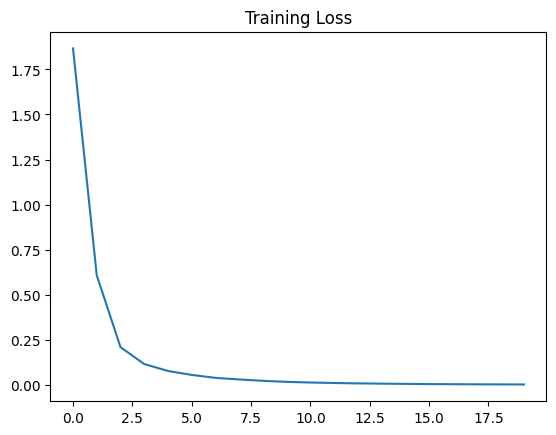

In [4]:
epochs = 20
losses = []

for epoch in range(epochs):
    running_loss = 0.0
    
    # Iterate over batches
    for inputs, labels in train_loader:
        # 1. Zero gradients
        optimizer.zero_grad()
        
        # 2. Forward pass
        outputs = model(inputs)
        
        # 3. Calculate Loss
        loss = criterion(outputs, labels)
        
        # 4. Backward Pass
        loss.backward()
        
        # 5. Optimize
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.title("Training Loss")
plt.show()

## Evaluation
We have to manually switch to evaluation mode (`model.eval()`) and disable gradients (`torch.no_grad()`).

In [5]:
model.eval() # Set model to evaluation mode

with torch.no_grad():
    outputs = model(X_tensor_test)
    # Get the index of the max log-probability (The predicted class)
    _, predicted = torch.max(outputs, 1)

    # Calculate Accuracy
    correct = (predicted == y_tensor_test).sum().item()
    accuracy = correct / len(y_tensor_test)
    
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9806



---
# Real World ANN: Customer Churn
---
We now move from the academic dataset to a **Real World Problem**.

# Real World ANN: Customer Churn Prediction

This is a **Tabular Data** problem. This is 90% of real-world business ML.

### The Problem
A Telecom company wants to know: *"Will this customer leave us next month?"*
We have data like:
- **Numerical:** Monthly Charges, Tenure (months).
- **Categorical:** Contract Type (Month-to-month, One year), Internet Service (DSL, Fiber).

### The Challenges
1.  **Data Loading:** It's not in `sklearn`. We need a **Custom Dataset Class**.
2.  **Preprocessing:** Neural Networks hate text ('Fiber Optic'). We must convert them to numbers.\n
3.  **Imbalance:** Most people *don't* churn. Accuracy is a lie. We watch **F1-Score**.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Create Synthetic "Telco Churn" Data
# In real life, you would do: df = pd.read_csv('churn.csv')

np.random.seed(42)
n_samples = 2000

data = {
    # Numerical Features
    'tenure': np.random.randint(1, 72, n_samples),
    'monthly_charges': np.random.uniform(20, 100, n_samples),
    
    # Categorical Features
    'contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples),
    'internet_service': np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples),
    'payment_method': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_samples),
    
    # Target (0 = Stay, 1 = Churn)
    # We make churn somewhat correlated with 'Month-to-month' contracts and High charges
    'churn': np.zeros(n_samples)
}

df = pd.DataFrame(data)

# Simulate real world logic: People with Month-to-month contracts churn more
mask = (df['contract'] == 'Month-to-month') & (df['monthly_charges'] > 60)
df.loc[mask, 'churn'] = np.random.choice([0, 1], size=mask.sum(), p=[0.4, 0.6]) # 60% churn rate for this group

print("Sample Data:")
display(df.head())

Sample Data:


,tenure,monthly_charges,contract,internet_service,payment_method,churn
0,52,40.373650,Two year,DSL,Electronic check,0.0
1,15,87.269726,Two year,Fiber optic,Mailed check,0.0
2,61,23.074108,One year,Fiber optic,Electronic check,0.0
3,21,92.140959,One year,Fiber optic,Mailed check,0.0
4,24,56.918197,Month-to-month,Fiber optic,Credit card,0.0


## Preprocessing
PyTorch only eats numbers. 
- **Categoricals:** LabelEncode them (0, 1, 2).
- **Numericals:** StandardScale them (Mean 0, Std 1).

In [7]:
# Separate Features and Target
X = df.drop('churn', axis=1)
y = df['churn'].values

# Encode Categoricals
cat_cols = ['contract', 'internet_service', 'payment_method']
num_cols = ['tenure', 'monthly_charges']

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale Numericals
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Convert to Float32 usually
X = X.values.astype(np.float32)
y = y.astype(np.float32).reshape(-1, 1) # Reshape for Binary Cross Entropy (N, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## The Custom Dataset Class (Important!)
This is how you load **ANY** data in PyTorch (Images, Audio, CSVs).
You must implement `__len__` and `__getitem__`.

In [8]:
class ChurnDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = torch.tensor(X_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

train_ds = ChurnDataset(X_train, y_train)
test_ds = ChurnDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

## The Model (Binary Classifier)
- **Output:** 1 Neuron with **Sigmoid** activation (Probability 0 to 1).
- **Loss:** `BCELoss` (Binary Cross Entropy).

In [9]:
class ChurnModel(nn.Module):
    def __init__(self, input_dim):
        super(ChurnModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3) # Drop 30% of neurons to prevent overfitting
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.output = nn.Linear(32, 1) # Binary Output
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return self.sigmoid(x)

model = ChurnModel(input_dim=X.shape[1])
print(model)

ChurnModel(
  (layer1): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Training

Epoch 5, Loss: 0.1566
Epoch 10, Loss: 0.1263
Epoch 15, Loss: 0.1265
Epoch 20, Loss: 0.1215


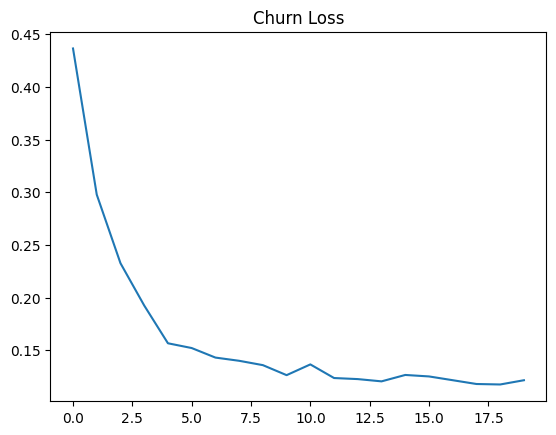

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses = []

model.train()
for epoch in range(epochs):
    batch_losses = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    
    train_losses.append(np.mean(batch_losses))
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {np.mean(batch_losses):.4f}")

plt.plot(train_losses)
plt.title("Churn Loss")
plt.show()

## Evaluation
Accuracy is dangerous here. If 90% of customers stay, a model that says "Everyone Stays" has 90% accuracy but is useless.
We look at **Precision, Recall, and F1-Score**.

In [11]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pred = (outputs > 0.5).float() # Threshold at 0.5
        y_pred_list.extend(y_pred.numpy())
        y_true_list.extend(labels.numpy())

print(classification_report(y_true_list, y_pred_list, target_names=['Stay', 'Churn']))

              precision    recall  f1-score   support

        Stay       0.99      0.95      0.97       356
       Churn       0.68      0.91      0.78        44

    accuracy                           0.94       400
   macro avg       0.83      0.93      0.87       400
weighted avg       0.95      0.94      0.95       400



About 32% of predicted churns are false alarms (Low precision for Churn)

The model is aggressive about predicting churn:

It would rather flag extra people than miss real churners